## Transformer architecture
Preparing data

In [1]:
from tensorflow import keras

batch_size = 32
train_ds = keras.preprocessing.text_dataset_from_directory("aclImdb/train",
                                                           batch_size=batch_size)
val_ds = keras.preprocessing.text_dataset_from_directory("aclImdb/val",
                                                         batch_size=batch_size)
test_ds = keras.preprocessing.text_dataset_from_directory("aclImdb/test",
                                                          batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Data translating

In [2]:
# prepare a dataset that only yields raw text inputs(no label)
text_only_train_ds = train_ds.map(lambda x, y:x)

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_length = 600
max_tokens = 20000
text_vectorization = TextVectorization(max_tokens=max_tokens,
                                      output_mode="int",
                                      output_sequence_length=max_length)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))

Transformer encoder implemented as a subclassed Layer

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim 
        self.dense_dim = dense_dim 
        self.num_heads = num_heads 
        self.attention = layers.MultiHeadAttention(num_heads=num_heads,
                                                   key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),
                                            layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        
    def call(self, inputs, mask=None): 
        if mask is not None:
            mask = mask[:, tf.newaxis, :] 
        attention_output = self.attention(inputs, inputs,
                                              attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self): 
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,})
        return config

Text classification model that combines the Transformer encoder and a pooling layer

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None, ), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
# model.summary()

Training and evaluating the Transformer encoder based model.

In [9]:
callbacks = [keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                             save_best_only=True)]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model("transformer_encoder.keras",
                                custom_objects={"TransformerEncoder": TransformerEncoder}) 
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
625/625 [==============================] - 115s 177ms/step - loss: 0.4834 - accuracy: 0.7747 - val_loss: 0.3367 - val_accuracy: 0.8564
Epoch 2/20
625/625 [==============================] - 110s 176ms/step - loss: 0.3237 - accuracy: 0.8590 - val_loss: 0.3417 - val_accuracy: 0.8598
Epoch 3/20
625/625 [==============================] - 110s 176ms/step - loss: 0.2578 - accuracy: 0.8954 - val_loss: 0.2831 - val_accuracy: 0.8936
Epoch 4/20
625/625 [==============================] - 111s 177ms/step - loss: 0.2017 - accuracy: 0.9213 - val_loss: 0.3336 - val_accuracy: 0.8858
Epoch 5/20
625/625 [==============================] - 111s 177ms/step - loss: 0.1611 - accuracy: 0.9377 - val_loss: 0.3593 - val_accuracy: 0.8766
Epoch 6/20
625/625 [==============================] - 111s 178ms/step - loss: 0.1350 - accuracy: 0.9481 - val_loss: 0.3945 - val_accuracy: 0.8664
Epoch 7/20
625/625 [==============================] - 112s 179ms/step - loss: 0.1158 - accuracy: 0.9570 - val_loss: 0.4859 -

88.4% test accuracy

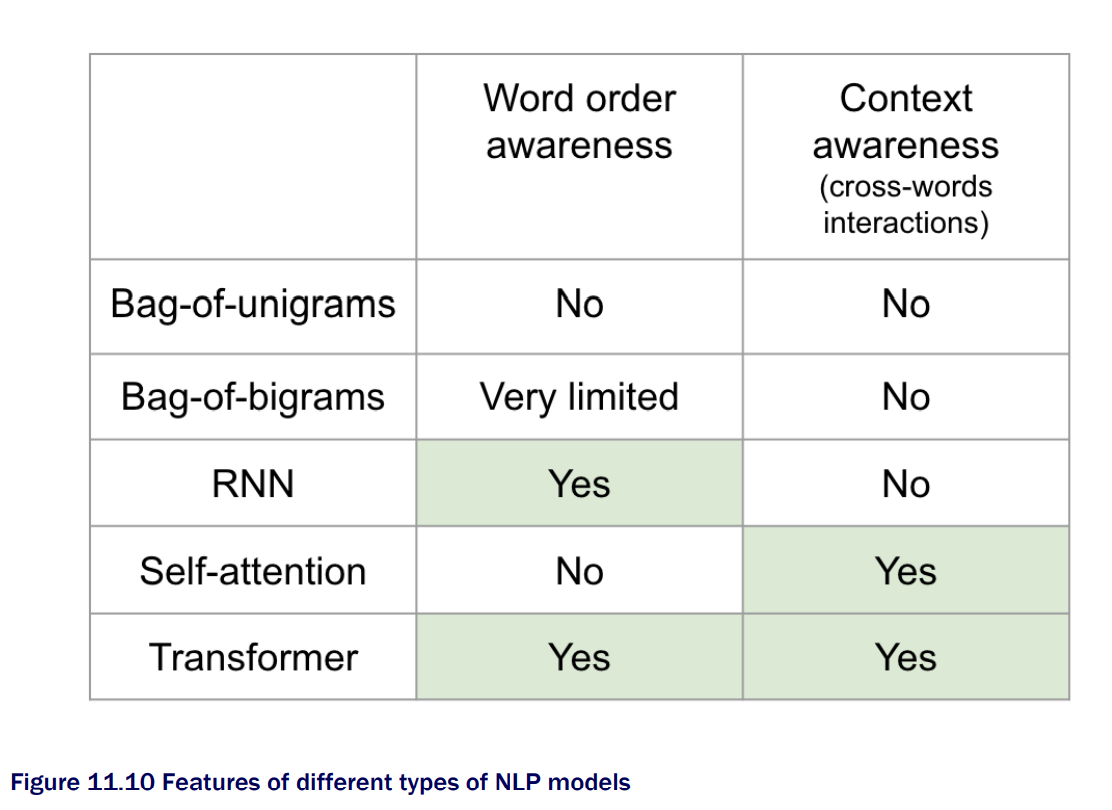

In [11]:
from IPython.display import Image

Image(filename='p395.png')

### Using positional encoding to reinject order information
we're going to add to each word embedding the word's position in the sentence. Our input word embeddings will have two components: the usual word vector, which represents the word independently of any specific context, and a position vector, which represents the position of the word in the current sentence. __Hopefully, the model will figure out how to best leverage this additional information__.

Implementing positional embedding as a subclassed layer

In [12]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs): 
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim) 
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    
    def compute_mask(self, inputs, mask=None): 
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,})
        return config

### Putting all together: a text-classification transformer

In [13]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) 
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
# model.summary()

callbacks = [keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                             save_best_only=True)]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model("full_transformer_encoder.keras",
                                custom_objects={"TransformerEncoder": TransformerEncoder,
                                                "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
625/625 [==============================] - 114s 180ms/step - loss: 0.4818 - accuracy: 0.7771 - val_loss: 0.3529 - val_accuracy: 0.8668
Epoch 2/20
625/625 [==============================] - 112s 180ms/step - loss: 0.2389 - accuracy: 0.9060 - val_loss: 0.2849 - val_accuracy: 0.8868
Epoch 3/20
625/625 [==============================] - 112s 179ms/step - loss: 0.1777 - accuracy: 0.9323 - val_loss: 0.3401 - val_accuracy: 0.8918
Epoch 4/20
625/625 [==============================] - 112s 180ms/step - loss: 0.1419 - accuracy: 0.9466 - val_loss: 0.5123 - val_accuracy: 0.8686
Epoch 5/20
625/625 [==============================] - 113s 180ms/step - loss: 0.1212 - accuracy: 0.9570 - val_loss: 0.3573 - val_accuracy: 0.8888
Epoch 6/20
625/625 [==============================] - 112s 180ms/step - loss: 0.1028 - accuracy: 0.9631 - val_loss: 0.4671 - val_accuracy: 0.8824
Epoch 7/20
625/625 [==============================] - 112s 180ms/step - loss: 0.0901 - accuracy: 0.9690 - val_loss: 0.4480 -

### 11.4.4 When to use sequence models over bag-of-words models?
When approaching a new text classification task, we should pay attention to the ratio between the number of samples in our trainind data and the mean number of words per sample. Sequence models work best when lots of training data is available and when each sample is relatively short.

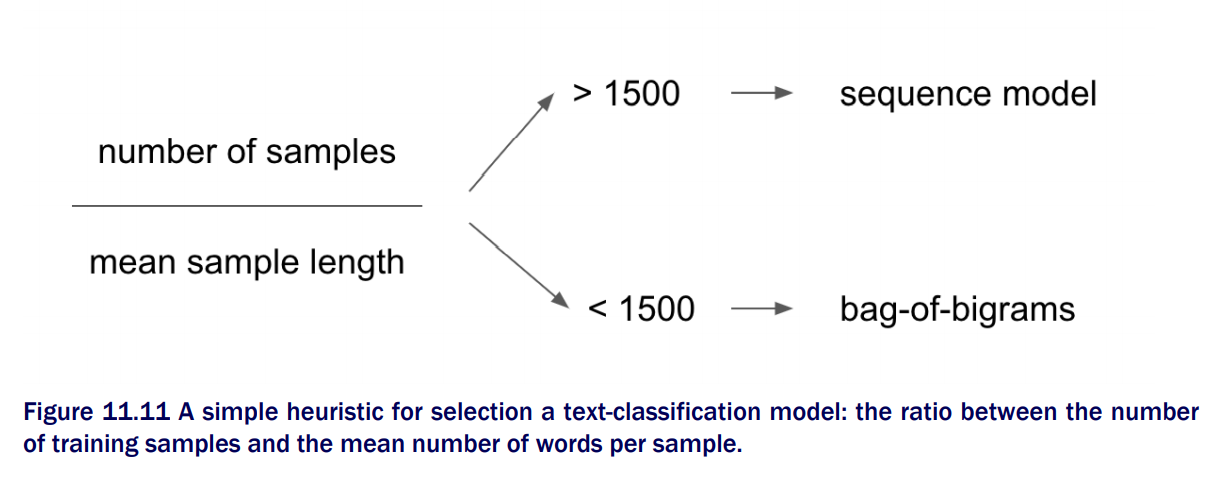

In [14]:
from IPython.display import Image

Image(filename='p399.png')